In [53]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Any

## DTLZ2 Problem

In [54]:
class DTLZ2:
    """
    DTLZ2 Problem Class

    Parameters:
    ---------
        n_var (int): Number of decision variables
        n_obj (int): Number of objectives
    """

    def __init__(self, n_var=5, n_obj=2):
        """
        Initialize the DTLZ2 problem with given number of variables and objectives.
        Parameters:
        ---------
            n_var (int): Number of decision variables
            n_obj (int): Number of objectives
        """
        assert n_var >= n_obj, "Number of variables must be greater than or equal to number of objectives."

        self.n_var = n_var
        self.n_obj = n_obj
        self.lb = 0.
        self.ub = 1.

    def g(self, X_m):
        """
        Calculate the g function for the DTLZ2 problem.

        Parameters:
        ---------
            X_m (numpy.ndarray): Decision variables for the g function.
        """

        return np.sum(np.square(X_m - 0.5), axis=1)

    def obj_func(self, X_, g, alpha=1):
        """
        Calculate the objective function values for the DTLZ2 problem.

        Parameters:
        ---------
            X_ (numpy.ndarray): Decision variables.
            g (numpy.ndarray): g function values.
            alpha (float): Exponent for the cosine and sine functions.
        Returns:
        ---------
            numpy.ndarray: Objective function values.
        """
        f = []
        for i in range(self.n_obj):
            _f = (1 + g)
            for j in range(self.n_obj - (i + 1)):  # Cosine product for first (M-1) objectives
                _f *= np.cos(np.power(X_[:, j], alpha) * np.pi / 2.0)
            if i > 0:
                _f *= np.sin(np.power(X_[:, self.n_obj - i - 1], alpha) * np.pi / 2.0)  # Only the last variable in sine

            f.append(_f)

        return np.column_stack(f)

    def evaluate(self, x):
        """
        Evaluate the DTLZ2 problem for a given set of decision variables.

        Parameters:
        ---------
            x (numpy.ndarray): Decision variables.

        Returns:
        ---------
            numpy.ndarray: Objective function values.
        """
        X, X_M = x[:, :self.n_var - self.n_obj + 1], x[:, self.n_var - self.n_obj + 1:]

        g = self.g(X_M)
        return self.obj_func(X, g)

## Problem Class

In [55]:
class FunctionalProblem:
    """
    Functional Problem Class

    This class allows the user to define their own objective functions. The objective functions are expected as a list of functions e.g.,

    objs = [
        lambda x: np.sum((x + 2) ** 2),
        lambda x: np.sum((x - 2) ** 2)
    ]

    Parameters:
    ---------
        n_var (int): Number of decision variables
        objs (list): List of objective functions
        lb (float): Lower bound for decision variables
        ub (float): Upper bound for decision variables
    """

    def __init__(self, n_var=1, objs=list, lb=0., ub=1.):
        """
        Initialise the FunctionalProblem Class

        Parameters:
        ---------
            n_var (int): Number of decision variables
            objs (list): List of objective functions
            lb (float): Lower bound for decision variables
            ub (float): Upper bound for decision variables
        """

        self.n_var = n_var
        self.objs = objs
        self.n_dim = len(objs)
        self.lb = lb
        self.ub = ub

    def evaluate(self, X: np.ndarray):
        """
        Evaluate the objective functions for a given population.

        Parameters:
        ----------
            X (np.ndarray): Decision space values

        Returns:
        ----------
            np.ndarray: Obejctive function values
        """

        F = np.zeros((X.shape[0], len(self.objs)))
        for i, x in enumerate(X):
            for j, obj in enumerate(self.objs):
                F[i][j] = obj(x)

        return F


## Hypervolume Calculation

In [56]:
def hypervolume(points: np.ndarray, ref: np.ndarray) -> float:
    """
    Calculate the hypervolume of a front of points

    Parameters:
    ----------
        points (numpy.ndarray): Points in the objective space
        ref (numpy.ndarray): Reference point for hypervolume calculation

    Returns:
        float: Hypervolume value
    """
    n, d = points.shape

    if n == 0:
        return 0.0
    if d == 1:
        # 1D case: sum lengths of intervals
        return np.max(ref[0] - points[:, 0])

    # Sort by last dimension (d-th)
    sorted_indices = np.argsort(points[:, -1])
    points = points[sorted_indices]

    volume = 0.0
    prev = ref[-1]

    while len(points) > 0:
        # Take the last point (largest in last dimension)
        p = points[-1]
        height = prev - p[-1]

        # Slice space below this point
        below = points[points[:, -1] < p[-1]]
        if len(below) > 0:
            sub_volume = hypervolume(below[:, :-1], ref[:-1])
        else:
            sub_volume = np.prod(ref[:-1] - p[:-1])  # base case: box to ref

        volume += sub_volume * height
        prev = p[-1]
        points = points[:-1]

    return volume



## Individual Class

In [57]:
class Individual:
    """
    Class representing each individulal in the population.
    """

    def __init__(self):
        self.X = None
        self.F = None
        self.front = None
        self.crowding_distance = 0.0

    def reset_crowding_distance(self):
        """
        Reset the crowding distance of the individual.
        """
        self.crowding_distance = 0.0

    def reset_front(self):
        """
        Reset the front of the individual.
        """
        self.front = 0

    def setX(self, X):
        """
        Set the decision vector of the individual.

        Parameters:
        ----------
            X (numpy.ndarray): Decision vector
        """
        self.X = X

    def setF(self, F):
        """
        Set the objective vector of the individual.

        Parameters:
        ----------
            F (numpy.ndarray): Objective vector
        """
        self.F = F

    def getX(self):
        """
        Get the decision vector of the individual.

        Returns:
        ----------
            numpy.ndarray: Decision vector
        """
        return self.X

    def getF(self):
        """
        Get the objective vector of the individual.

        Returns:
        ----------
            numpy.ndarray: Objective vector
        """
        return self.F


## Population Class

In [58]:
class Population:
    """
    Class representing a population of individuals.

    Parameters:
    ----------
        pop_size (int): Size of the population
    """

    def __init__(self, pop_size: int = 100):
        """
        Initialise the Population Class

        Parameters:
        ----------
            pop_size (int): Size of the population
        """
        self.pop_size = pop_size
        self.pop = np.array([Individual() for _ in range(pop_size)])

    def initialise_population(self, problem: Any) -> None:
        """
        Initialise the population with random decision vectors within the bounds of the problem.

        Parameters:
        ----------
            problem (Any): Problem instance
        """

        X = np.random.uniform(problem.lb, problem.ub, (self.pop_size, problem.n_var))
        for i, ind in enumerate(self.pop):
            ind.setX(X[i])

    def set_population(self, inds: List[Individual]):
        """
        Set the population with a list of individuals.

        Parameters:
        ----------
            inds (List[Individual]): List of individuals
        """

        assert len(
            inds) == self.pop_size, f"Population size mismatch. Got {len(inds)} individuals. Expected {self.pop_size}."
        self.pop = inds

    def set_decision_vectors(self, X):
        """
        Set the decision vectors of the individuals in the population.

        Parameters:
        ----------
            X (numpy.ndarray): Decision vectors
        """
        assert len(X) == self.pop_size

        for i, ind in enumerate(self.pop):
            ind.setX(X[i])

    def set_objectives(self, F):
        """
        Set the objective vectors of the individuals in the population.

        Parameters:
        ----------
            F (numpy.ndarray): Objective vectors
        """
        assert len(F) == self.pop_size
        for i, ind in enumerate(self.pop):
            ind.setF(F[i])

    def get(self, var):
        """
        Get the decision vectors or objective vectors of the individuals in the population.

        Parameters:
        -----------
            var (str): Variable name ("X" for decision vectors, "F" for objective vectors)
        """

        assert var in ["X", "F"], "Invalid variable name. Use 'X' for decision vectors or 'F' for objective vectors."

        if var == "X":
            return np.array([ind.getX() for ind in self.pop])
        elif var == "F":
            return np.array([ind.getF() for ind in self.pop])
        else:
            raise ValueError("Invalid variable name.")

    def crowding_distance(self, front):
        """
        Calculate the crowding distance for a front of individuals.

        Parameters:
        ----------
            front (List[Individual]): List of individuals in the front
        """

        if len(front) == 0:
            return

        num_objectives = len(front[0].F)

        for ind in front:
            ind.reset_crowding_distance()

        for m in range(num_objectives):
            # Sort them by their objective vector values
            front.sort(key=lambda ind: ind.F[m])

            # Extreme values have larger
            front[0].crowding_distance = front[-1].crowding_distance = 5e2

            min_f = front[0].F[m]
            max_f = front[-1].F[m]

            if max_f == min_f:
                continue

            for i in range(1, len(front) - 1):
                front[i].crowding_distance += (front[i + 1].F[m] - front[i - 1].F[m]) / (max_f - min_f)

    def non_dominated_sort(self):
        """
        Perform non-dominated sorting on the population.
        """

        def ndf(population):
            """
            Non-dominated front sorting function.

            Parameters:
            ----------
                population (List[Individual]): List of individuals in the population

            Returns:
            ----------
                numpy.ndarray: Boolean array indicating if each individual is non-dominated
            """
            points = np.array([ind.F for ind in population])
            A = points[:, np.newaxis, :]
            B = points[np.newaxis, :, :]

            better_or_equal = np.all(B <= A, axis=2)
            strictly_better = np.any(B < A, axis=2)
            dominated = better_or_equal & strictly_better
            np.fill_diagonal(dominated, False)

            return ~np.any(dominated, axis=1)

        for ind in self.pop:
            ind.reset_front()

        fronts = []
        data = self.pop[:]
        front_number = 0

        while len(data) > 0:
            f = ndf(data)
            front = [data[i] for i in range(len(data)) if f[i]]
            fronts.append(front)
            data = [data[i] for i in range(len(data)) if not f[i]]

            for ind in front:
                ind.front = front_number
            front_number += 1

        return fronts

    def crowded_tournament_selection(self):
        """
        Perform crowded tournament selection to select parents for crossover.

        Returns:
        ----------
            List[Individual]: Selected individuals for crossover
        """
        fronts = self.non_dominated_sort()
        for front in fronts:
            self.crowding_distance(front)

        selected = []
        while len(selected) < self.pop_size:
            individuals = np.random.choice(self.pop, 2, replace=True)

            if individuals[0].front < individuals[1].front:
                selected.append(individuals[0])
            elif individuals[0].front > individuals[1].front:
                selected.append(individuals[1])
            else:
                if individuals[0].crowding_distance > individuals[1].crowding_distance:
                    selected.append(individuals[0])
                else:
                    selected.append(individuals[1])

        return selected

    def eliminate_duplicates(self, eps=1e-16):
        """
        Remove duplicate individuals from the population.

        Parameters:
        ----------
            eps (float): Tolerance for considering individuals as duplicates
        """

        X = np.array([ind.getX() for ind in self.pop])
        distances = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
        np.fill_diagonal(distances, np.inf)

        duplicates = np.any(distances < eps, axis=1)

        unique_indices = np.where(~duplicates)[0]
        self.pop = self.pop[unique_indices]
        self.pop_size = len(self.pop)

    def merge(self, other):
        """
        Merge two populations.

        Parameters:
        ----------
            other (Population): Another population to merge with

        Returns
            self (Population): Merged population
        """
        self.pop = np.concatenate([self.pop, other.pop])
        self.pop_size = len(self.pop)

        return self

    def difference_based_termination(self, prev_pop, reference_point, eps=1e-5):
        """
        Check if the population has changed significantly compared to the previous generation.

        Parameters:
        ----------
            prev_pop (Population): Previous population
            reference_point (numpy.ndarray): Reference point for hypervolume calculation
            eps (float): Tolerance for considering the populations as different

        Returns:
        ----------
            bool: True if the populations are very similar within eps, False otherwise
        """
        current_X = self.get("F")
        prev_X = prev_pop.get("F")

        hv_current = hypervolume(current_X, reference_point)
        hv_prev = hypervolume(prev_X, reference_point)

        diff = hv_current - hv_prev

        if diff < eps:
            return True
        return False



## Genetic Operators
- #### Simulated Binary Crossover (SBX)
- #### Polynomial Mutation



In [59]:
def sbx_crossover(parents, eta_c=2, crossover_prob=0.9, lb=0., ub=1.):
    """
    Perform Simulated Binary Crossover (SBX) on a given parent population.

    Parameters:
    -----------
        parents (np.ndarray): Parent population of shape (N, D), where N is the number of parents, and D is the number of genes per individual.
        eta_c (float): Distribution index that controls the spread of offspring.
        crossover_prob (float): Probability of performing crossover.
        lb (float): Lower bound in decision space.
        ub (float): Upper bound in decision space.

    Returns:
    -----------
        numpy.ndarray: Offspring population of the same shape as parents.
    """

    if parents.ndim == 1:
        parents = parents.reshape(-1, 1)

    num_parents, num_genes = parents.shape
    offspring = np.copy(parents)

    for i in range(0, num_parents - 1, 2):  # Pairwise crossover
        if np.random.rand() < crossover_prob:
            p1, p2 = parents[i], parents[i + 1]
            c1, c2 = np.copy(p1), np.copy(p2)

            for j in range(num_genes):
                u = np.random.rand()
                if u < 0.5:
                    beta_q = np.power((2 * u), (1 / (eta_c + 1)))
                else:
                    beta_q = np.power((1 / (2 * (1 - u))), (1 / (eta_c + 1)))

                c1[j] = (0.5 * (1 + beta_q) * p1[j] + (1 - beta_q) * p2[j])
                c2[j] = (0.5 * (1 - beta_q) * p1[j] + (1 + beta_q) * p2[j])

                c1 = np.clip(c1, lb, ub)
                c2 = np.clip(c2, lb, ub)

            offspring[i], offspring[i + 1] = c1, c2

    return offspring


def polynomial_mutation(X, prob, eta, lb, ub):
    """
    Perform polynomial mutation on a given population.

    Parameters:
    -----------
        X (np.ndarray): Population of shape (N, D), where N is the number of individuals, and D is the number of genes per individual.
        prob (float): Mutation rate.
        eta (int): Mutation distribution index.
        xl (float): Lower bound of the gene.
        xu (float): Upper bound of the gene.

    Returns:
        np.ndarray: Mutated population of the same shape as X.
    """

    xl = np.array([lb for _ in range(X.shape[1])])
    xu = np.array([ub for _ in range(X.shape[1])])

    mut = np.random.rand(X.shape[0]) < prob
    _X = np.copy(X)

    for i, x in enumerate(X):
        if mut[i]:
            delta_1 = (x - xl) / (xu - xl)
            delta_2 = (xu - x) / (xu - xl)

            r = np.random.rand(1)
            if r <= 0.5:
                dq1 = (2. * r) + ((1. - (2 * r)) * np.power((1 - delta_1), (eta + 1)))
                delta_q = (np.power(dq1, 1 / (eta + 1))) - 1
            else:
                dq1 = (2. * (1. - r)) + ((2. * (r - 0.5)) * np.power((1. - delta_2), (eta + 1)))
                delta_q = 1 - np.power(dq1, 1 / (eta + 1))

            x_mutated = x + (delta_q * (xu - xl))

            x_mutated = np.clip(x_mutated, xl, xu)

            _X[i] = x_mutated

    return _X


def genetic_opertation(parents, eta_c=15, crossover_prob=0.9, mutation_rate=0.1, eta_m=20, lb=-2., ub=2.):
    """
    Perform genetic operations (crossover and mutation) on a given parent population.

    Parameters:
    -----------
        parents Population: Parent population
        eta_c (float): Distribution index that controls the spread of offspring.
        crossover_prob (float): Probability of performing crossover.
        mutation_rate (float): Probability of mutating a gene.
        eta_m (int): Mutation distribution index.
        lb (float): Lower bound of the gene.
        ub (float): Upper bound of the gene.

    Returns:
    ----------
        numpy.ndarray: Offspring population of the same shape as parents.
    """

    parents = parents.get("X")

    crossover_offspring = sbx_crossover(parents, eta_c, crossover_prob)

    mutated_offspring = np.array(polynomial_mutation(crossover_offspring, mutation_rate, eta_m, lb, ub))

    offspring = Population(pop_size=len(parents))
    offspring.set_decision_vectors(mutated_offspring)

    return offspring

## Elitism Selection

In [60]:
def elitism(parents: Population, offspring: Population, pop_size=100):
    """
    Perform elitism selection to select the next generation.

    Parameters:
    -----------
        parents Population: Parent population of shape (N, D), where N is the number of parents, and D is the number of genes per individual.
        offspring Population: Evaluated Offspring population of the same shape as parents.

    Returns:
    -----------
        next_generation Population: The population for the next iteration.
    """

    offspring.eliminate_duplicates()
    combined_population = parents.merge(offspring)
    fronts = combined_population.non_dominated_sort()

    next_generation = []

    for f in fronts:
        if len(next_generation) + len(f) > pop_size:
            combined_population.crowding_distance(f)

            f.sort(key=lambda ind: ind.crowding_distance, reverse=True)

            next_generation.extend(f[:pop_size - len(next_generation)])
        else:
            next_generation.extend(f)

    next_gen = Population(pop_size=pop_size)
    next_gen.set_population(next_generation)

    return next_gen

## Multi-Level Perceptron (MLP) Regression

In [61]:

class MLPRegressor:
    """
    Multi-Layer Perceptron (MLP) Regressor Class

    Parameters:
    ----------
        layer_sizes (list): List of integers representing the number of neurons in each layer.
        learning_rate (float): Learning rate for the optimizer.
        epochs (int): Number of training epochs.
    """
    def __init__(self, layer_sizes, learning_rate=0.01, epochs=1000):
        """
        Initialise the MLP Regressor with given parameters.

        Parameters:
        ----------
            layer_sizes (list): List of integers representing the number of neurons in each layer.
            learning_rate (float): Learning rate for the optimizer.
            epochs (int): Number of training epochs.
        """

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = []
        self.biases = []
        self._initialize_weights()
        self.loss = []

    def _initialize_weights(self):
        """
        Initialize the weights and biases of the MLP.
        """
        for i in range(len(self.layer_sizes) - 1):
            self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * 0.01)
            self.biases.append(np.zeros((1, self.layer_sizes[i + 1])))

    def _relu(self, x):
        """
        ReLU activation function.

        Parameters:
        ----------
            x (numpy.ndarray): Input array.
        """

        return np.maximum(0, x)

    def _relu_derivative(self, x):
        """
        ReLU derivative function for the backward pass.

        Parameters:
        ----------
            x (numpy.ndarray): Input array.
        """

        return (x > 0).astype(float)

    def _forward(self, X):
        """
        Forward pass through the MLP.

        Parameters:
        ----------
            X (numpy.ndarray): Input data.

        Returns:
        ----------
            activations (list): List of activations from the forward pass.
            pre_activations (list): List of pre-activations from the forward pass as the output layer has no activation function.
        """

        activations = [X]
        pre_activations = []
        for W, b in zip(self.weights[:-1], self.biases[:-1]):
            Z = np.dot(activations[-1], W) + b
            pre_activations.append(Z)
            A = self._relu(Z)
            activations.append(A)
        Z_out = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        pre_activations.append(Z_out)
        activations.append(Z_out)  # Output layer has no activation function for regression
        return activations, pre_activations

    def _backward(self, activations, pre_activations, Y):
        """
        Backward pass through the MLP to compute gradients.

        Parameters:
        ----------
            activations (list): List of activations from the forward pass.
            pre_activations (list): List of pre-activations from the forward pass.
            Y (numpy.ndarray): True labels.

        Returns:
        ----------
            dW (list): List of gradients for weights.
            db (list): List of gradients for biases.
        """

        m = Y.shape[0]
        dW = []
        db = []
        dZ = activations[-1] - Y  # Mean Squared Error derivative

        for i in reversed(range(len(self.weights))):
            dW_i = np.dot(activations[i].T, dZ) / m
            db_i = np.sum(dZ, axis=0, keepdims=True) / m
            dW.insert(0, dW_i)
            db.insert(0, db_i)
            if i > 0:
                dZ = np.dot(dZ, self.weights[i].T) * self._relu_derivative(pre_activations[i - 1])

        return dW, db

    def _update_weights(self, dW, db):
        """
        Update the weights and biases using the computed gradients.

        Parameters:
        ----------
            dW (list): List of gradients for weights.
            db (list): List of gradients for biases.
        """

        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i] -= self.learning_rate * db[i]

    def fit(self, X, Y):
        """
        Train the MLP using the given data.

        Parameters:
        ----------
            X (numpy.ndarray): Input data.
            Y (numpy.ndarray): True labels.
        """

        for epoch in range(self.epochs):
            activations, pre_activations = self._forward(X)
            dW, db = self._backward(activations, pre_activations, Y)
            self._update_weights(dW, db)

            if epoch % 100 == 0:
                self.loss.append(np.mean((activations[-1] - Y) ** 2))

        print(f"Training Complete - Loss: {self.loss[-1]:.4f}")

    def predict(self, X):
        """
        Predict the output for a given input using the trained MLP.

        Parameters:
        ----------
            X (numpy.ndarray): Input data.
        """

        activations, _ = self._forward(X)
        return activations[-1]

In [62]:
def run(n_gen, pop_size, problem, lb, ub, reference_point):
    """
    Run standard NSGA-II algorithm for a given number of generations and population size.

    Parameters:
    ----------
        n_gen (int): Number of generations.
        pop_size (int): Population size.
        problem (Any): Problem instance.
        lb (float): Lower bound for decision variables.
        ub (float): Upper bound for decision variables.
        reference_point (numpy.ndarray): Reference point for hypervolume calculation.

    Returns:
        Population: Final population after running the algorithm.
    """

    pop = Population(pop_size=pop_size)
    pop.initialise_population(problem)
    pop.set_objectives(problem.evaluate(pop.get("X")))

    gen = 0

    while gen < n_gen:
        prev_pop = pop
        # Perform crowded tournament selection to select parents
        parents = Population(pop_size=pop_size)
        parents.set_population(pop.crowded_tournament_selection())

        # Perform Crossover and mutation to generate offspring
        offspring = genetic_opertation(parents, lb=lb, ub=ub)

        # Evaluate the offspring
        offspring.set_objectives(problem.evaluate(offspring.get("X")))

        # Use Non-dominated sorting and crowded distance to select the next generation
        pop = elitism(parents, offspring, pop_size)

        gen += 1
        print(f"Generation {gen} completed.")

        if gen % 2 == 0:
            if pop.difference_based_termination(prev_pop, reference_point, eps=.01):
                break

    return pop


def run_surrogate(n_gen:int, pop_size:int, problem:Any, mlp:MLPRegressor, FE_max:int, R:int, epsilon:float, reference_point:np.ndarray):
    """
    Run surrogate-assisted NSGA-II algorithm for a given number of generations and population size.

    Parameters:
    -----------
        n_gen (int): Number of generations.
        pop_size (int): Population size.
        problem (Any): Problem instance.
        mlp (MLPRegressor): MLP Regressor instance.
        FE_max (int): Maximum number of function evaluations.
        R (int): Interval for evaluating the surrogate model.
        epsilon (float): Error threshold for retraining the surrogate model.
        reference_point (numpy.ndarray): Reference point for hypervolume calculation.

    Returns:
        Population: Final population after running the algorithm.
        List[float]: Mean Absolute Error (MAE) values during training.
    """

    MAE = []

    X = np.random.randn(FE_max, problem.n_var)
    y = problem.evaluate(X)
    mlp.fit(X, y)

    gen = 0
    new_samples = []

    pop = Population(pop_size=pop_size)
    pop.initialise_population(problem)
    pop.set_objectives(mlp.predict(pop.get("X")))

    while gen < n_gen:
        prev_pop = pop
        # Perform crowded tournament selection to select parents
        parents = Population(pop_size=pop_size)
        parents.set_population(pop.crowded_tournament_selection())

        # Perform Crossover and mutation to generate offspring
        offspring = genetic_opertation(parents, lb=problem.lb, ub=problem.ub)

        # Evaluate the offspring
        if gen % R == 0:
            Xs = offspring.get("X")
            true_objectives = problem.evaluate(Xs)
            predicted_objectives = mlp.predict(Xs)
            offspring.set_objectives(true_objectives)

            MAE.append(np.mean(np.abs(predicted_objectives - true_objectives)))

            #index = np.random.randint(0, len(Xs))
            #print(f"Xs : {Xs[index]} - {true_objectives[index]} : {predicted_objectives[index]} : Error : {np.mean(np.abs(true_objectives[index] - predicted_objectives[index]))}")

            for i in range(len(Xs)):
                error = np.mean(np.abs(true_objectives[i] - predicted_objectives[i]))

                # If error exceeds threshold, add the point to retraining data
                if error > epsilon:
                    new_samples.append((Xs[i], true_objectives[i]))

            if new_samples:

                X_new, Y_new = [i[0] for i in new_samples], [i[1] for i in new_samples]
                X = np.vstack((X, np.array(X_new)))
                y = np.vstack((y, np.array(Y_new)))

                if X.shape[0] > 2000:
                    X = X[-2000:]
                    y = y[-2000:]

                mlp.fit(X, y)
                new_samples.clear()

        else:
            offspring.set_objectives(mlp.predict(offspring.get("X")))

        # Use Non-dominated sorting and crowded distance to select the next generation
        pop = elitism(parents, offspring)

        gen += 1

        print(f"Generation {gen} completed.")

        if gen % 2 == 0:
            if pop.difference_based_termination(prev_pop, reference_point, eps=.01):
                break

    return pop, MAE


In [63]:

n_var = 5
n_obj = 2

mlp = MLPRegressor([n_var, 5, n_obj], learning_rate=0.01, epochs=1000)

objs = [
    lambda x: np.sum((x + 2) ** 2),
    lambda x: np.sum((x - 2) ** 2)
]
lb, ub = 0, 1

problem = DTLZ2(n_var=n_var, n_obj=n_obj)

#problem = FunctionalProblem(n_var=n_var, objs=objs, lb=lb, ub=ub)


In [64]:
ref_point = np.array([2, 2, 2])
#pop = run(10, 100, problem, lb, ub, ref_point)
pop, mae = run_surrogate(11, 100, problem, mlp, FE_max=200, R=3, epsilon=0.1, reference_point=ref_point)
F = np.array(pop.get("F"))

Training Complete - Loss: 1.7642
Training Complete - Loss: 0.9597
Generation 1 completed.
Generation 2 completed.
Difference: 0.09120338509393067
Generation 3 completed.
Training Complete - Loss: 0.6664
Generation 4 completed.
Difference: 0.16728808767604875
Generation 5 completed.
Generation 6 completed.
Difference: -0.1343851288024176


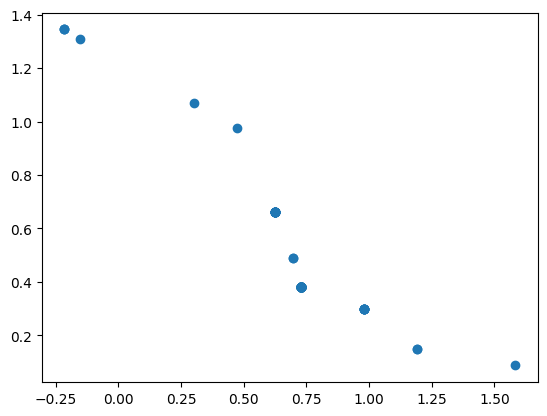

100


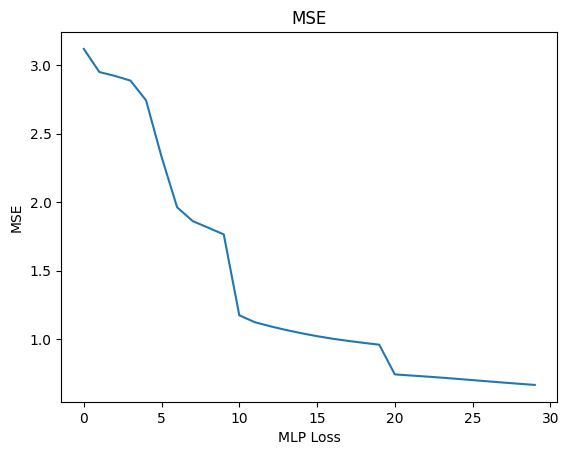

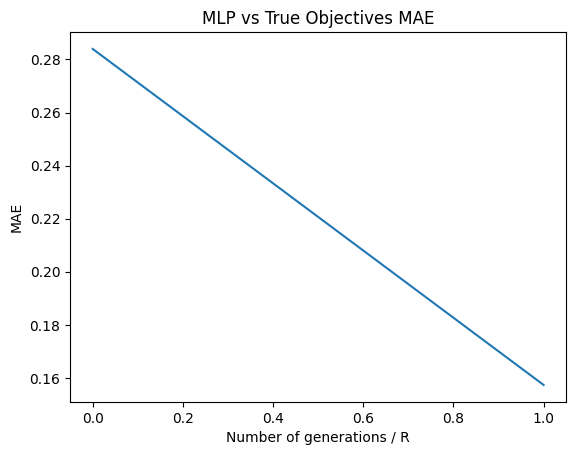

In [65]:
if n_obj == 3:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(F[:, 0], F[:, 1], F[:, 2])
    plt.show()
else:
    plt.scatter(F[:, 0], F[:, 1])
    plt.show()
print(len(F))

plt.plot(mlp.loss)
plt.title("MSE")
plt.xlabel("MLP Loss")
plt.ylabel("MSE")
plt.show()

plt.plot(mae)
plt.title("MLP vs True Objectives MAE")
plt.xlabel("Number of generations / R")
plt.ylabel("MAE")
plt.show()